In [58]:
import pandas as pd
import numpy as np

import rfr_remote
import rfr_ipynb

import matplotlib.pyplot as plt

## Data  loading and analysis
There are separate files for each of the targets being predicted. There are 8 targets total, so there are 8 separate data sets.

- These data sets contain the descriptors and targets for the training data. There are ~1500 points in the formation energy sets (a, b) and ~1000 points in the transition level sets (p32-m23). 
- The descriptors in each set are different, and were selected through expanding an original set of features (SISSO) and then using LASSO to select those most highly correlated with outputs.

**Formation Energies**

In [59]:
lasso_a = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_HA_7.7.csv')

In [60]:
lasso_b = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_HB_7.7.csv')

The formation energy training sets by semiconductor type are:
- ~71 % II-VI semicondcutors
- ~15 % III-V semiconductors
- ~14 % IV-IV semicondcutors


The formation energy training sets by semiconductor site are:
- ~63 % interstitial defect sites
- ~37 % substitutional defect sites

In [61]:
rfr_ipynb.counter(lasso_a, 'Type')

Total entries:  1494


,Type,percent
II-VI,1067,71.42
III-V,218,14.59
IV-IV,209,13.99


In [62]:
rfr_ipynb.counter(lasso_a, 'Site')

Total entries:  1494


,Site,percent
M_i_A,320,21.42
M_i_neut,316,21.15
M_i_B,306,20.48
M_A,293,19.61
M_B,259,17.34


------

**Transition Energy Levels**

In [43]:
lasso_p32 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(+3,+2)_7.7.csv')

In [44]:
lasso_p21 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(+2,+1)_7.7.csv')

In [45]:
lasso_0p1 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(+1,0)_7.7.csv')

In [46]:
lasso_0m1 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(0,-1)_7.7.csv')

In [47]:
lasso_m12 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(-1,-2)_7.7.csv')

In [48]:
lasso_m23 = pd.read_csv('./xiaofeng_lasso/dataset_7p7/Lasso_(-2,-3)_7.7.csv')

The formation energy sets are:
- ~53 % II-VI semicondcutors
- ~23 % IV-IV semicondcutors
- ~23 % III-V semiconductors

The formation energy training sets by semiconductor site are:
- ~64 % interstitial defect sites
- ~36 % substitutional defect sites

In [63]:
rfr_ipynb.counter(lasso_p32, 'Type')

Total entries:  983


,Type,percent
II-VI,523,53.2
III-V,230,23.4
IV-IV,230,23.4


In [64]:
rfr_ipynb.counter(lasso_p32, 'Site')

Total entries:  983


,Site,percent
M_i_A,217,22.08
M_i_neut,214,21.77
M_i_B,199,20.24
M_A,188,19.13
M_B,165,16.79


-----

### Best random forest regression model parameters for each output 
**(determined through Bayesian optimization)**
- **∆H (A-rich)	:** num_trees=600, max_depth=10, max_feat='auto', min_samp_leaf=2, min_samples_split=15
- **∆H (B-rich)	:** num_trees=1000, max_depth=10, max_feat='auto', min_samp_leaf=3, min_samples_split=15
- **(+3/+2) :** num_trees=450, max_depth=7, max_feat='auto', min_samp_leaf=3, min_samples_split=3
- **(+2/+1) :** num_trees=600, max_depth=9, max_feat='auto', min_samp_leaf=7, min_samples_split=2
- **(+1/0) :** num_trees=150, max_depth=10, max_feat='auto', min_samp_leaf=8, min_samples_split=12
- **(0/-1) :** num_trees=150, max_depth=8, max_feat='auto', min_samp_leaf=5, min_samples_split=3
- **(-1/-2) :** num_trees=750, max_depth=10, max_feat='auto', min_samp_leaf=8, min_samples_split=12
- **(-2/-3) :** num_trees=450, max_depth=10, max_feat='sqrt', min_samp_leaf=2, min_samples_split=14

--------
------
## How to use the functions:
### 1. Find out how well the model is predicting (for each output)
**RFR model:**
Random forest regression models with  with cross validation can be run using the function ``rfr_predictor``. The function takes in a data set (lasso_a, lasso_p32, etc) and performs RFR n-folds times, using a different train and test set in each fold. This function will return train and test dictionaries where the key is the fold of CV, and the value is a dataframe containing type, ab, ipmurity, site, dft values, and predicted values for every point in the train/test set in that fold. 

**RMSE of model:**
A root mean squared error (RMSE), a metric for how well a ML model is predicting, can be calculated for each fold of the cross validation using ``rmse_calculator``. The dictionaries returned from ``rfr_predictor`` are the inputs, and the function returns a table where each row is the training and testing set RMSE values for each fold of the cross validation. The last row of the table is the mean and standard deviation across all the folds. By changing the arguement "output_type" to "type" or "site", the function can output values for how the model predicted specific types of compounds, ie a II-VI, or compounds with an interstitial defect. In these cases the function will output 3 (type) or 2 (defect site) tables. The tables are for type: II-VI, III-V, IV-IV and for site: substitutional, interstitial defect site.

---------
OR
### 2. Find the average prediction (w/ uncertainty) + parity plot
**Average Prediction:**
The average prediction (plus uncertainty) for each point in the total set as both a train and test point. The average and uncertainty come from the n-folds of cross validation performed n-folds times. The tables returned (train/test) have the actual dft points, the mean of the predicted points, and the standard deviation of that prediction which from each interation of the model. Use ``rfr_pp_predictor`` to get these averages.


**Parity plots:**
The parity plots are a visual check of how the model is predicting. The axes are the true output values vs the predicted output values, and each point represents an impurity doped semiconductor compound. If the model is predicting perfectly the points would fall on a line of slope 1. The function used to plot these is ``parity_plot``. The dataframes returned from ``rfr_pp_predictor`` are the inputs, and this function returns parity plots which can show points differentiated by type and defect site (as above) by changing 'output_type'.

## Formation Energies

### ∆H (A-rich)	

#### RMSE table

dHA_traindic, dHA_testdic= \
    rfr_remote.rfr_predictor(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                             min_samp_leaf=2, min_samples_split=15,
                             num_trees=600, folds=10)

This is OVERALL how the model predicts for the ∆H (A-rich), formation energy of the dopant in A-rich chemical potential, target. The RMSE values are in eV, and can be read as the amount of uncertainty of all the predictions for this target. The closer this value is to 0, the better the model is predicting. The test RMSE is describes how the model predicts on "never before seen data", while the train RMSE is used to ensure the model is not overfitting and giving falsely confident predictions.

In [66]:
#output_type = 'none' returns the overall RMSE of train and test
dHA_rmse = rfr_remote.rmse_calculator(dHA_traindic, dHA_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
dHA_rmse_26, dHA_rmse_35, dHA_rmse_44 = \
    rfr_remote.rmse_calculator(dHA_traindic, dHA_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
dHA_rmse_sub, dHA_rmse_int = \
    rfr_remote.rmse_calculator(dHA_traindic, dHA_testdic,
                                      output_type='site')

In [67]:
# what an overall dataframe looks like
dHA_rmse

,train rmse,test rmse
0,0.63925,1.05946
1,0.63301,1.12319
2,0.638934,1.10377
3,0.631445,0.997664
4,0.619726,1.18414
5,0.635581,1.00834
6,0.641014,0.894301
7,0.632608,1.01759
8,0.633081,1.16947
9,0.648237,0.82359


In [68]:
# what an dataframe by site looks like
dHA_rmse_26

,train rmse II-VI,test rmse II-VI
0,0.451901,0.66517
1,0.441393,0.68818
2,0.44959,0.621957
3,0.444567,0.579457
4,0.436638,0.670683
5,0.44376,0.717792
6,0.443944,0.702528
7,0.447241,0.658303
8,0.451755,0.612518
9,0.44901,0.609857


The dataset used to train the model was made up of overwhelmingly II-VI semiconductor data, so it's interesting to look at how the model predicts each type of semiconductor separately. From the results, it's clear that the model predicts II-VI semiconductors with much higher accuracy than the III-V or IV-IV semiconductor types.

In [69]:
rfr_ipynb.type_site_df('type', [dHA_rmse_26, dHA_rmse_35, dHA_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.45 +/- 0.005,0.65 +/- 0.045
1,III-V,0.86 +/- 0.017,1.44 +/- 0.297
2,IV-IV,1.05 +/- 0.024,1.79 +/- 0.386


The dataset used to train the model has more compounds with interstitial defect sites versus substitutional. From the results, it's clear that the model predicts compounds with defects at interstitial sites more accurately than substitutional sites.

In [70]:
rfr_ipynb.type_site_df('site', [dHA_rmse_sub, dHA_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.7 +/- 0.012,1.19 +/- 0.219
1,int,0.6 +/- 0.013,0.92 +/- 0.138


#### Parity Plots
For the plots I have added a timer (thanks to tqdm) that updates a progress bar for every time the cv is repeated.

In [71]:
dHA_traindf, dHA_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_a, d_start=5, max_depth=10, max_feat='auto', 
                                min_samp_leaf=2, min_samples_split=15, num_trees=600,
                                folds=5)

The parity plot for ∆H (A-rich)	clearly shows that at higher values, the model does a worse job predicting. The data seems to lean off the parity line as the predicted formation energies get higher in value. Evaluating the training dataset I found that <100 points had formation energy values above ~6.5 eV, maybe explaining the bad predictions.

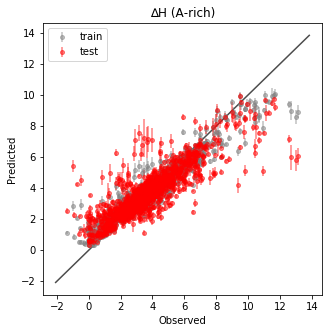

In [72]:
rfr_remote.parity_plot(dHA_traindf, dHA_testdf, 'none', '∆H (A-rich)')

Mirroring the information from the RMSE tables, the II-VI values are predicted the most accurately (they stay closest to the parity line). The III-V and IV-IV points stray sometimes far from the line.

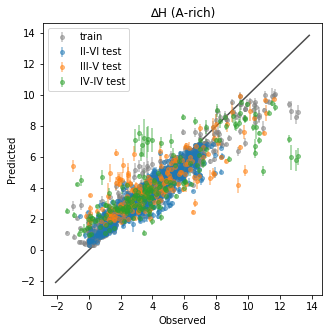

In [73]:
rfr_remote.parity_plot(dHA_traindf, dHA_testdf, 'type', '∆H (A-rich)')

Interestingly, the parity plot doesn't obviously show that the interstitial sites are predicted much better than the substitutional defect sites. Both seem to have points that stray far from parity line.

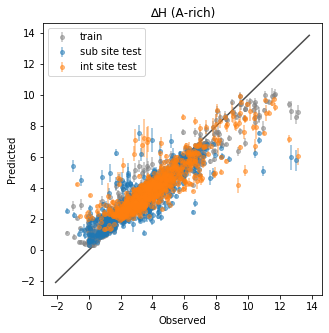

In [74]:
rfr_remote.parity_plot(dHA_traindf, dHA_testdf, 'site', '∆H (A-rich)')

This plots the deviation in prediction from the real value (prediction error), vs the standard deviation from the folds of CV. Ideally, these two would have a positive and linear relationship, where a greater standard deviation would indicate a very incorrect prediction. Though there seems to be some positive correlation, it appears that most of the test points that have a large error do not have a large standard deviation and most are clustered toward the bottom left of the plot

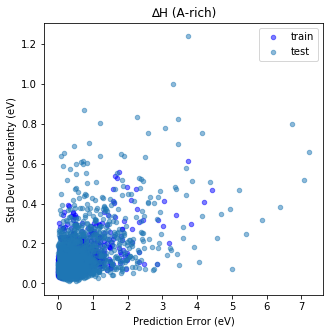

In [76]:
pred_stddev_plot(dHA_traindf, dHA_testdf, '∆H (A-rich)')

### ∆H (B-rich)	

In [77]:
dHB_traindic, dHB_testdic= \
    rfr_remote.rfr_predictor(lasso_b, d_start=5,  max_depth=10, max_feat='auto', 
                             min_samp_leaf=3, min_samples_split=15,
                             num_trees=1000, folds=10)

In [78]:
#output_type = 'none' returns the overall RMSE of train and test
dHB_rmse = rfr_remote.rmse_calculator(dHB_traindic, dHB_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
dHB_rmse_26, dHB_rmse_35, dHB_rmse_44 = \
    rfr_remote.rmse_calculator(dHB_traindic, dHB_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
dHB_rmse_sub, dHB_rmse_int = \
    rfr_remote.rmse_calculator(dHB_traindic, dHB_testdic,
                                      output_type='site')

This is overall prediction for the ∆H (B-rich), formation energy of the dopant in B-rich chemical potential, target. The range of possible for this target is larger than ∆H (A-rich), which could be why the RMSE is slightly higher.

In [79]:
dHB_rmse

,train rmse,test rmse
0,0.704148,1.37882
1,0.713478,1.26268
2,0.72995,1.05076
3,0.706851,1.25005
4,0.714602,1.1642
5,0.713145,1.16007
6,0.724459,0.999179
7,0.711601,1.10943
8,0.71495,1.27934
9,0.730334,1.04857


As in the formation energy for A-rich sites, it's clear that the model predicts II-VI semiconductors with much higher accuracy than the III-V or IV-IV semiconductor types.

In [81]:
rfr_ipynb.type_site_df('type', [dHB_rmse_26, dHB_rmse_35, dHB_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.56 +/- 0.011,0.86 +/- 0.118
1,III-V,0.93 +/- 0.034,1.56 +/- 0.431
2,IV-IV,1.07 +/- 0.019,1.79 +/- 0.368


As in the formation energy for A-rich sites, it's clear that the model predicts compounds with defects at interstitial sites more accurately than substitutional sites.

In [82]:
rfr_ipynb.type_site_df('site', [dHB_rmse_sub, dHB_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.79 +/- 0.016,1.34 +/- 0.2
1,int,0.67 +/- 0.009,1.05 +/- 0.101


### Parity Plots
The parity plots for the B-rich site show very similar results to the A-rich sites with higher values not being predicted as well.

In [83]:
dHB_traindf, dHB_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_b, d_start=5,  max_depth=10, max_feat='auto', 
                                min_samp_leaf=3, min_samples_split=15,
                                num_trees=1000, folds=5)

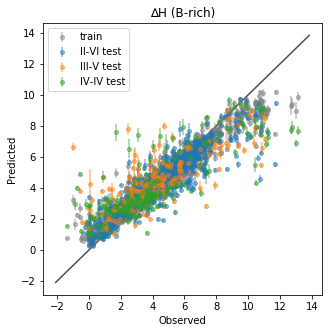

In [84]:
rfr_remote.parity_plot(dHB_traindf, dHB_testdf, 'type', '∆H (B-rich)')

Interestingly, the parity plot doesn't obviously show that the interstitial sites are predicted much better than the substitutional defect sites. Both seem to have points that stray far from parity line.

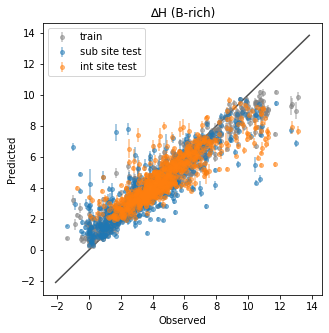

In [85]:
rfr_remote.parity_plot(dHB_traindf, dHB_testdf, 'site', '∆H (B-rich)')

----
----
## Transition Levels

### (+3/+2)

#### RMSE table

In [87]:
p32_traindic, p32_testdic= \
    rfr_remote.rfr_predictor(lasso_p32, d_start=5, max_depth=7, max_feat='auto', 
                             min_samp_leaf=3, min_samples_split=3,
                             num_trees=450, folds=10)

In [88]:
#output_type = 'none' returns the overall RMSE of train and test
p32_rmse = rfr_remote.rmse_calculator(p32_traindic, p32_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
p32_rmse_26, p32_rmse_35, p32_rmse_44 = \
    rfr_remote.rmse_calculator(p32_traindic, p32_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
p32_rmse_sub, p32_rmse_int = \
    rfr_remote.rmse_calculator(p32_traindic, p32_testdic,
                                      output_type='site')

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [89]:
p32_rmse

,train rmse,test rmse
0,0.230805,0.331659
1,0.227808,0.312405
2,0.227099,0.391208
3,0.225072,0.406865
4,0.226384,0.381236
5,0.228389,0.347661
6,0.234774,0.313665
7,0.23266,0.331495
8,0.228958,0.316348
9,0.228365,0.298959


In the formation energy dataset, II-VI semiconductors make up a smaller (but still significant) portion of the data. Though, unlike the formation energies, the predicition across types of semiconductors are very similar to one another.

In [90]:
rfr_ipynb.type_site_df('type', [p32_rmse_26, p32_rmse_35, p32_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.22 +/- 0.004,0.32 +/- 0.04
1,III-V,0.27 +/- 0.007,0.41 +/- 0.07
2,IV-IV,0.21 +/- 0.005,0.31 +/- 0.069


Predictions by type of defect site are also very similar for the (+3/+2) transition level

In [91]:
rfr_ipynb.type_site_df('site', [p32_rmse_sub, p32_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.21 +/- 0.004,0.33 +/- 0.061
1,int,0.24 +/- 0.003,0.35 +/- 0.042


#### Parity Plot
The interstitial sites predict better than the substitutional sites. This isn't very clear from the parity plot where the two seem to stay on the parity line for lower energy predictions and they start to deviate for higher energy predictions. As can be seen from the poitns, most of the values lie below -0.5 eV (where the strongest predictions are).

In [92]:
p32_traindf, p32_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_p32, d_start=5, max_depth=7, max_feat='auto', 
                                min_samp_leaf=3, min_samples_split=3,
                                num_trees=450, folds=5)

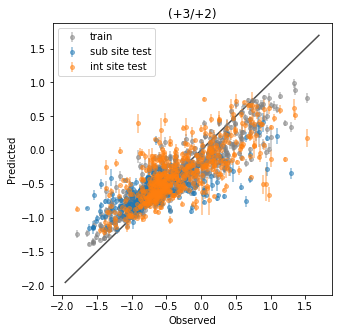

In [100]:
rfr_remote.parity_plot(p32_traindf, p32_testdf, 'site', '(+3/+2)')

### (+2/+1)

#### RMSE table

In [94]:
p21_traindic, p21_testdic= \
    rfr_remote.rfr_predictor(lasso_p21, d_start=5, max_depth=9, max_feat='auto', 
                             min_samp_leaf=7, min_samples_split=2,
                             num_trees=600, folds=10)

In [95]:
#output_type = 'none' returns the overall RMSE of train and test
p21_rmse = rfr_remote.rmse_calculator(p21_traindic, p21_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
p21_rmse_26, p21_rmse_35, p21_rmse_44 = \
    rfr_remote.rmse_calculator(p21_traindic, p21_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
p21_rmse_sub, p21_rmse_int = \
    rfr_remote.rmse_calculator(p21_traindic, p21_testdic,
                                      output_type='site')

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [96]:
p21_rmse.loc[10]

train rmse    0.26 +/- 0.003
test rmse      0.38 +/- 0.05
Name: 10, dtype: object

As in the previous transition level, the predicition across types of semiconductors are very similar to one another.

In [97]:
rfr_ipynb.type_site_df('type', [p21_rmse_26, p21_rmse_35, p21_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.25 +/- 0.003,0.35 +/- 0.053
1,III-V,0.3 +/- 0.005,0.42 +/- 0.083
2,IV-IV,0.27 +/- 0.01,0.37 +/- 0.113


Predictions by type of defect site are also very similar for the (+3/+2) transition level

In [98]:
rfr_ipynb.type_site_df('site', [p21_rmse_sub, p21_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.29 +/- 0.004,0.44 +/- 0.074
1,int,0.25 +/- 0.005,0.33 +/- 0.059


#### Parity Plots

In [99]:
p21_traindf, p21_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_p21, d_start=5, max_depth=9, max_feat='auto', 
                                min_samp_leaf=7, min_samples_split=2,
                                num_trees=600, folds=5)

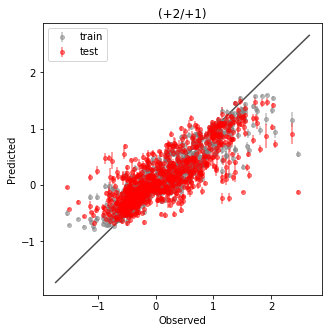

In [102]:
rfr_remote.parity_plot(p21_traindf, p21_testdf, 'none', '(+2/+1)')

In this plot vs the dHA plot, the deviation in predictions seem to be less strongly correlated with the predictions with higher standard deviation. Higher levels of uncertainty are associated with lower prediction errors.

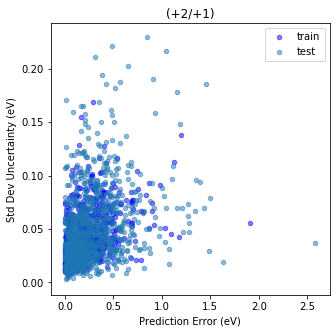

In [104]:
pred_stddev_plot(p21_traindf, p21_testdf, '(+2/+1)')

### (+1/0)

#### RMSE table

In [106]:
p01_traindic, p01_testdic= \
    rfr_remote.rfr_predictor(lasso_0p1, d_start=5, max_depth=10, max_feat='auto', 
                             min_samp_leaf=8, min_samples_split=12,
                             num_trees=150, folds=10)

In [107]:
#output_type = 'none' returns the overall RMSE of train and test
p01_rmse = rfr_remote.rmse_calculator(p01_traindic, p01_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
p01_rmse_26, p01_rmse_35, p01_rmse_44 = \
    rfr_remote.rmse_calculator(p01_traindic, p01_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
p01_rmse_sub, p01_rmse_int = \
    rfr_remote.rmse_calculator(p01_traindic, p01_testdic,
                                      output_type='site')

The range of values for the transition values is much smaller than the formation energies, and the error in the predictions reflect that. 

In [108]:
p01_rmse.loc[10]

train rmse    0.26 +/- 0.003
test rmse     0.37 +/- 0.034
Name: 10, dtype: object

The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [109]:
rfr_ipynb.type_site_df('type', [p01_rmse_26, p01_rmse_35, p01_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.25 +/- 0.005,0.36 +/- 0.053
1,III-V,0.26 +/- 0.006,0.37 +/- 0.071
2,IV-IV,0.27 +/- 0.008,0.39 +/- 0.06


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [110]:
rfr_ipynb.type_site_df('site', [p01_rmse_sub, p01_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.33 +/- 0.007,0.48 +/- 0.085
1,int,0.21 +/- 0.004,0.29 +/- 0.035


#### Parity Plots

From the RMSE table we would expect the III-V semiconductors to predic the worst. Though it seems that there are some of parity orange points, it's hard to tell the difference between the sc types.

In [112]:
p01_traindf, p01_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_0p1, d_start=5, max_depth=10, max_feat='auto', 
                                min_samp_leaf=8, min_samples_split=12,
                                num_trees=150, folds=5)

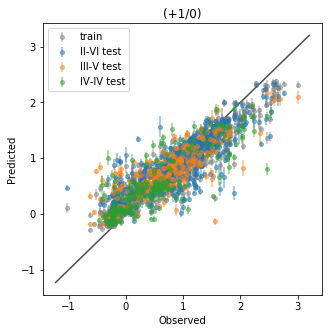

In [119]:
rfr_remote.parity_plot(p01_traindf, p01_testdf, 'type', '(+1/0)')

### (0/-1)

#### RMSE table

In [114]:
m01_traindic, m01_testdic= \
    rfr_remote.rfr_predictor(lasso_0m1, d_start=5, max_depth=8, max_feat='auto', 
                             min_samp_leaf=5, min_samples_split=3,
                             num_trees=150, folds=10)

In [115]:
#output_type = 'none' returns the overall RMSE of train and test
m01_rmse = rfr_remote.rmse_calculator(m01_traindic, m01_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
m01_rmse_26, m01_rmse_35, m01_rmse_44 = \
    rfr_remote.rmse_calculator(m01_traindic, m01_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
m01_rmse_sub, m01_rmse_int = \
    rfr_remote.rmse_calculator(m01_traindic, m01_testdic,
                                      output_type='site')

The variation between folds is much smaller than the formation energies.

In [116]:
m01_rmse

,train rmse,test rmse
0,0.222186,0.359584
1,0.217534,0.378169
2,0.22011,0.346697
3,0.219159,0.355567
4,0.226031,0.310988
5,0.221264,0.342002
6,0.22894,0.293403
7,0.216169,0.411404
8,0.215824,0.439143
9,0.223028,0.289274


The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [117]:
rfr_ipynb.type_site_df('type', [m01_rmse_26, m01_rmse_35, m01_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.22 +/- 0.004,0.35 +/- 0.055
1,III-V,0.23 +/- 0.008,0.37 +/- 0.093
2,IV-IV,0.21 +/- 0.009,0.32 +/- 0.094


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [118]:
rfr_ipynb.type_site_df('site', [m01_rmse_sub, m01_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.29 +/- 0.008,0.47 +/- 0.088
1,int,0.17 +/- 0.004,0.27 +/- 0.038


#### Parity Plots

From the RMSE table we would expect the substitutional defect compounds to predict the worse than interstitial. At lower energies (between -0.5 and 0.5) the predictions for the substitutional sights all seem high. Besides that, most points stick fairly close to the parity line.

In [121]:
m01_traindf, m01_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_0m1, d_start=5, max_depth=8, max_feat='auto', 
                                min_samp_leaf=5, min_samples_split=3,
                                num_trees=150, folds=5)

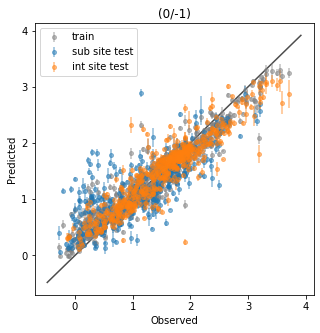

In [122]:
rfr_remote.parity_plot(m01_traindf, m01_testdf, 'site', '(0/-1)')

### (-1/-2)

#### RMSE table

In [123]:
m12_traindic, m12_testdic= \
    rfr_remote.rfr_predictor(lasso_m12, d_start=5, max_depth=10, max_feat='auto', 
                             min_samp_leaf=8, min_samples_split=12,
                             num_trees=750, folds=10)

In [124]:
#output_type = 'none' returns the overall RMSE of train and test
m12_rmse = rfr_remote.rmse_calculator(m12_traindic, m12_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
m12_rmse_26, m12_rmse_35, m12_rmse_44 = \
    rfr_remote.rmse_calculator(m12_traindic, m12_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
m12_rmse_sub, m12_rmse_int = \
    rfr_remote.rmse_calculator(m12_traindic, m12_testdic,
                                      output_type='site')

The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types (as in the previous 3 targets).

In [125]:
rfr_ipynb.type_site_df('type', [m12_rmse_26, m12_rmse_35, m12_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.22 +/- 0.004,0.3 +/- 0.037
1,III-V,0.26 +/- 0.01,0.35 +/- 0.118
2,IV-IV,0.22 +/- 0.011,0.29 +/- 0.114


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [126]:
rfr_ipynb.type_site_df('site', [m12_rmse_sub, m12_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.28 +/- 0.006,0.39 +/- 0.069
1,int,0.2 +/- 0.005,0.27 +/- 0.046


#### Parity Plots

As seen in the previous plot, the lower energy substitutional points (0-1.5 eV) are predicted to much higher than their actual values. The other points seem to stick close to the parity line.

In [127]:
m12_traindf, m12_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_m12, d_start=5, max_depth=10, max_feat='auto', 
                                min_samp_leaf=8, min_samples_split=12,
                                num_trees=750, folds=5)

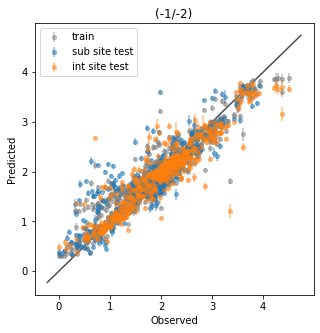

In [128]:
rfr_remote.parity_plot(m12_traindf, m12_testdf, 'site', '(-1/-2)')

### (-2/-3)

#### RMSE table

In [129]:
m23_traindic, m23_testdic= \
    rfr_remote.rfr_predictor(lasso_m23, d_start=5, max_depth=10, max_feat='sqrt', 
                             min_samp_leaf=2, min_samples_split=14,
                             num_trees=450, folds=10)

In [130]:
#output_type = 'none' returns the overall RMSE of train and test
m23_rmse = rfr_remote.rmse_calculator(m23_traindic, m23_testdic,
                                      output_type='none')

#output_type = 'type' returns the RMSE of train and test separated by type
m23_rmse_26, m23_rmse_35, m23_rmse_44 = \
    rfr_remote.rmse_calculator(m23_traindic, m23_testdic,
                                      output_type='type')

#output_type = 'site' returns the RMSE of train and test separated by site
m23_rmse_sub, m23_rmse_int = \
    rfr_remote.rmse_calculator(m23_traindic, m23_testdic,
                                      output_type='site')

The variation between folds is much smaller than the formation energies.

In [131]:
m23_rmse

,train rmse,test rmse
0,0.189047,0.259791
1,0.193049,0.223145
2,0.192485,0.2346
3,0.189493,0.275873
4,0.1943,0.199376
5,0.187495,0.288033
6,0.194586,0.208485
7,0.190267,0.249723
8,0.181685,0.319408
9,0.190755,0.225557


The predicition across types of semiconductors are fairly similar to one another, though the III-V semiconductor seems to predict worse than the other types.

In [132]:
rfr_ipynb.type_site_df('type', [m23_rmse_26, m23_rmse_35, m23_rmse_44], 10)

,output,train rmse,test rmse
0,II-VI,0.2 +/- 0.006,0.25 +/- 0.062
1,III-V,0.18 +/- 0.007,0.24 +/- 0.078
2,IV-IV,0.16 +/- 0.006,0.22 +/- 0.057


Predictions by type of defect site are skewed toward interstitial defect sights (again, the training data set is ~60% interstitial, 40% substitutional)

In [133]:
rfr_ipynb.type_site_df('site', [m23_rmse_sub, m23_rmse_int], 10)

,output,train rmse,test rmse
0,sub,0.2 +/- 0.004,0.26 +/- 0.049
1,int,0.19 +/- 0.006,0.24 +/- 0.064


#### Parity Plots

There is very little standard deviation between folds in the cross validation leading to almost invisible error bars. But, the predictions stick on the parity line over the the whole energy range of predicted values.

In [134]:
m23_traindf, m23_testdf = \
    rfr_remote.rfr_pp_predictor(lasso_m23, d_start=5, max_depth=10, max_feat='sqrt', 
                             min_samp_leaf=2, min_samples_split=14,
                             num_trees=450, folds=5)

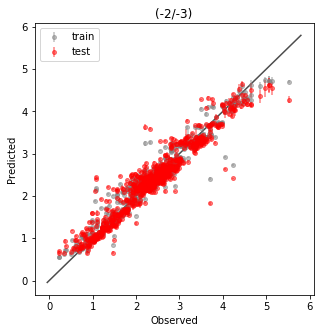

In [135]:
rfr_remote.parity_plot(m23_traindf, m23_testdf, 'none', '(-2/-3)')

In this plot vs the dHA plot and the (+2/+1) plot, the deviation in predictions seem to have medium correlation with the standard deviation across folds of the predictions. As in (+2/+1), mostly lower prediction errors give high standard deviations.

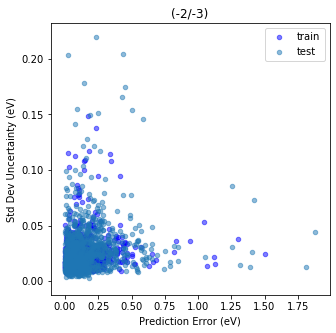

In [137]:
pred_stddev_plot(m23_traindf, m23_testdf, '(-2/-3)')

-----------
Prediction error vs standard deviation uncertainty plotting function

In [75]:
def pred_stddev_plot(df1, df2, plt_title):
    
   
    diff_train = np.abs(df1['dft_train'] - df1['mean_train'])
    std_train = df1['stddev_train']
    diff_test = np.abs(df2['dft_test'] - df2['mean_test'])
    std_test = df2['stddev_test']

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(diff_train, std_train, alpha = 0.5, label='train', color='blue', s = 20, zorder=2)
    ax.scatter(diff_test, std_test, alpha = 0.5, label='test', s = 20, zorder=3)

    ax.set_xlabel('Prediction Error (eV)')
    ax.set_ylabel('Std Dev Uncertainty (eV)')
    ax.set_title(plt_title)
    ax.legend()
    plt.show()